## HW3: 524 Spring 2023

## Question 01

In [6]:
using Pkg
Pkg.add("LinearAlgebra")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [7]:
# Define the coordinates of all agencies.
coordinates = [0 0; 20 20; 18 10; 30 12; 35 0; 33 25; 5 27; 5 10; 11 0; 2 15]

# Define the number of cars required and present at each agency.
required_cars = [10, 6, 8, 11, 9, 7, 15, 7, 9, 12]
cars_present = [8, 13, 4, 8, 12, 2, 14, 11, 15, 7]

using JuMP, HiGHS, LinearAlgebra, NamedArrays

m = Model(HiGHS.Optimizer)

# Compute the distance matrix.
dist_matrix = [1.3 * norm(coordinates[i, :] - coordinates[j, :]) for i in 1:10, j in 1:10]

@variable(m, cars[i = 1:10, j = 1:10] >= 0)
@objective(m, Min, 0.5 * sum(dist_matrix .* cars))

# Each agency has the required number of cars
@constraint(m, require[i = 1:10], sum(cars[i,j] for j in 1:10) == required_cars[i] )
@constraint(m, present[j = 1:10], sum(cars[i,j] for i in 1:10) == cars_present[j] )


# Define the constraints to ensure that the total number of cars is conserved
@constraint(m, sum(cars[i, j] for i in 1:10, j in 1:10) == sum(required_cars))

optimize!(m)
# solution = NamedArray( Int[value.(cars[i,j]) for i in required_cars, j in cars_present], (required_cars,cars_present), ("From","To") )
for i = 1:10
    for j = 1:10
        if value.(cars[i,j]) > 0
            println("From agency $i to agency $j: ", value.(cars[i,j]) )
        end
    end
end
    
println("Total cost of transport: \$", objective_value(m))

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
21 rows, 100 cols, 300 nonzeros
19 rows, 100 cols, 280 nonzeros
Presolve : Reductions: rows 19(-2); columns 100(-0); elements 280(-20)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 19(257) 0s
         21     1.5263901632e+02 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 21
Objective value     :  1.5263901632e+02
HiGHS run time      :          0.00
From agency 1 to agency 1: 8.0
From agency 1 to agency 9: 2.0
From agency 2 to agency 2: 6.0
From agency 3 to agency 2: 1.0
From agency 3 to agency 3: 4.0
From agency 3 to agency 9: 3.0
From agency 4 to agency 4: 8.0
From agency 4 to agency 5: 3.0
From agency 5 to agency 5: 9.0
From agency 6 to agency 2: 5.0
From agency 6 to agen

## Q2 Data for Stadium Building Problem

(This is the data needed for part (b). Part (a) of the problem will not need all this data.)

In [8]:
using JuMP

tasks = 1:18
durations = [2 16 9 8 10 6 2 2 9 5 3 2 1 7 4 3 9 1]
predecessors = ( [], [1], [2], [2], [3], [4,5], [4], [6], [4,6], [4], [6], [9], [7], [2], [4,14], [8,11,14], [12], [17] )
pred_dict = Dict(zip(tasks,predecessors));   # dictionary mapping tasks --> predecessors.

# additional columns of data (maximum reduction possible )
max_reduction =  [0,  3,  1,  2,  2,  1, 1, 0,  2,  1,  1, 0, 0,  2,  2, 1,  3, 0]  # max reduction (in weeks)
cost_reduction = [0, 30, 26, 12, 17, 15, 8, 0, 42, 21, 18, 0, 0, 22, 12, 6, 16, 0]  # cost of reduction ($1,000/week)
bonus_amount = 30     # bonus for expediting the project ($1,000/week )
;

pred_dict

Dict{Int64, Vector} with 18 entries:
  5  => [3]
  16 => [8, 11, 14]
  7  => [4]
  12 => [9]
  8  => [6]
  17 => [12]
  1  => Any[]
  4  => [2]
  6  => [4, 5]
  13 => [7]
  2  => [1]
  10 => [4]
  11 => [6]
  9  => [4, 6]
  15 => [4, 14]
  18 => [17]
  14 => [2]
  3  => [2]

## Q2a

In [9]:
using JuMP, HiGHS

m = Model(HiGHS.Optimizer)

@variable(m, start[tasks])

for i in tasks
    for j in pred_dict[i]
         @constraint(m, start[i] >= durations[j] + start[j] )
    end
end
@constraint(m, start[1] == 0)
@objective(m, Min, start[18] + durations[18])
optimize!(m)

println("Earliest possible date of completion: ", objective_value(m))

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
5 rows, 6 cols, 10 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-23); columns 0(-18); elements 0(-45) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  6.4000000000e+01
HiGHS run time      :          0.00
Earliest possible date of completion: 64.0


## Q2b

In [10]:
d = copy(durations)
m = Model(HiGHS.Optimizer)

for i in 1:length(max_reduction)
    if cost_reduction[i] <= 30
         d[i] = d[i] - max_reduction[i]
    end
end

@variable(m, start[tasks])

for i in tasks
     for j in pred_dict[i]
         @constraint(m, start[i] >= d[j] + start[j] )
     end
end
@constraint(m, start[1] == 0)
@objective(m, Min, start[18] + d[18])
optimize!(m)

println("Duration to maximize the profit: ", objective_value(m))

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
5 rows, 6 cols, 10 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-23); columns 0(-18); elements 0(-45) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  5.4000000000e+01
HiGHS run time      :          0.00
Duration to maximize the profit: 54.0


## Q3 (a)

In [11]:
using JuMP, HiGHS

m = Model(HiGHS.Optimizer)

capacity = 30 # MWh
demand = [43 40 36 36 35 38 41 46 49 48 47 47 48 46 45 47 50 63 75 75 72 66 57 50]

@variable(m, 0 <= purchased[1:24] <= 50)  #x, amount of electricity purchased from the utility of time i
@variable(m, 0 <= battery[1:24] <= 15)  #y amount of electricity stored in the battery at the beginning of hour i.
@variable(m, 0 <= charged[0:24] <= capacity)  #h amount of electricity charged from the battery of hour i

@constraint(m, charged[0] == 0) # battery starts completely drained
# Demand
@constraint(m, [i in 1:24], demand[i] <= purchased[i] + battery[i] + charged[i-1])
# Battery charge 
@constraint(m, [i in 1:24], charged[i] == charged[i-1] + purchased[i] + battery[i] - demand[i])

@objective(m, Min, 100 * sum(purchased[1:24]) + sum(battery[1:24])*400 )

optimize!(m)

println("Total cost: \$", objective_value(m))

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
48 rows, 72 cols, 166 nonzeros
41 rows, 62 cols, 141 nonzeros
Presolve : Reductions: rows 41(-8); columns 62(-11); elements 141(-28)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     3.8000000000e+04 Pr: 41(1867) 0s
         37     1.4340000000e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 37
Objective value     :  1.4340000000e+05
HiGHS run time      :          0.00
Total cost: $143400.0


In [12]:
# add the plotting package Gadfly
using Pkg
Pkg.add("Gadfly")
Pkg.build


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


build (generic function with 7 methods)

### Q3 (b)

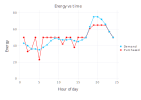

In [13]:
# this code will plot the demand (given in the starter code above) 
# and the value of the variable "purchased".
# Make sure the variable "purchased" is defined correctly by the code you write for part (a)
using Gadfly
plot(layer( x=1:24, y=demand, Geom.point, Geom.line ),
layer( x=1:24, y=(value.(purchased) + value.(battery)) , Geom.point, Geom.line, Theme(default_color=colorant"red") ),
Guide.xlabel( "Hour of day"), Guide.ylabel("Energy"), Guide.title("Energy vs time"), Guide.manual_color_key("",["Demand", "Purchased"],
                            [Gadfly.current_theme().default_color, "red"]))

During 17-21 hours is necessary to purchase electricity at the higher rate.

### Q3 (c)

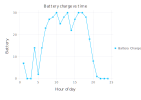

In [14]:
# this code will plot the variable battery charge vs. time of day. 
using Gadfly
plot(layer( x=1:24, y=(value.(charged)[1:24]) , Geom.point, Geom.line ),
Guide.xlabel( "Hour of day"), Guide.ylabel("Battery"), Guide.title("Battery charge vs time"), Guide.manual_color_key("",["Battery Charge"]))

### Q3 (d)

In [15]:
using JuMP, HiGHS

m = Model(HiGHS.Optimizer)

demand = [43 40 36 36 35 38 41 46 49 48 47 47 48 46 45 47 50 63 75 75 72 66 57 50]

@variable(m, 0 <= purchased[1:24] <= 50)  #x, amount of electricity purchased from the utility of time i
@variable(m, 0 <= battery[1:24] <= 15)  #y amount of electricity stored in the battery at the beginning of hour i.
@variable(m, 0 <= charged[0:24])  #h amount of electricity charged from the battery of hour i

@constraint(m, charged[0] == 0) # battery starts completely drained
# Demand
@constraint(m, [i in 1:24], demand[i] <= purchased[i] + battery[i] + charged[i-1])
# Battery charge 
@constraint(m, [i in 1:24], charged[i] == charged[i-1] + purchased[i] + battery[i] - demand[i])

@objective(m, Min, 100 * sum(purchased[1:24]) + sum(battery[1:24])*400 )

optimize!(m)

println("Total cost: \$", objective_value(m))
println("The maximum amount of charge stored in the battery at each hour: ")
for i in 1:24
    println("Hour $i: ", value.(charged[i]) )
end

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
48 rows, 72 cols, 166 nonzeros
40 rows, 64 cols, 166 nonzeros
Presolve : Reductions: rows 40(-9); columns 64(-9); elements 166(-3)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 40(2948) 0s
         19     1.2000000000e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 19
Objective value     :  1.2000000000e+05
HiGHS run time      :          0.00
Total cost: $120000.0
The maximum amount of charge stored in the battery at each hour: 
Hour 1: 7.0
Hour 2: 17.0
Hour 3: 31.0
Hour 4: 45.0
Hour 5: 60.0
Hour 6: 72.0
Hour 7: 81.0
Hour 8: 85.0
Hour 9: 86.0
Hour 10: 88.0
Hour 11: 91.0
Hour 12: 94.0
Hour 13: 96.0
Hour 14: 100.0
Hour 15: 105.0
Hour 16: 108.0
Hour 17: 108.0
Hour 18: 95.0


### Q3 (e)

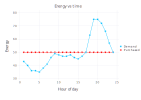

In [16]:
# this code will plot the demand and the value of the variable "purchased".
# Make sure the variable "purchased" is defined correctly by the code you write for part (a)
using Gadfly
plot(layer( x=1:24, y=demand, Geom.point, Geom.line ),
layer( x=1:24, y=(value.(purchased) + value.(battery)) , Geom.point, Geom.line, Theme(default_color=colorant"red") ),
Guide.xlabel( "Hour of day"), Guide.ylabel("Energy"), Guide.title("Energy vs time"), Guide.manual_color_key("",["Demand", "Purchased"],
                            [Gadfly.current_theme().default_color, "red"]))

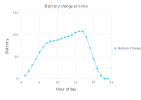

In [130]:
# this code will plot the variable battery charge vs. time of day. 
using Gadfly
plot(layer( x=1:24, y=(value.(charged)[1:24]) , Geom.point, Geom.line ),
Guide.xlabel( "Hour of day"), Guide.ylabel("Battery"), Guide.title("Battery charge vs time"), Guide.manual_color_key("",["Battery Charge"]))

With an infinite capacity battery, it is never necessary to purchase electricity at the higher rate because excess electricity purchased during low demand hours can be stored indefinitely in the battery and used during high demand hours.